<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0504.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 1. Forecast with numeric timeseries data
# 1.1 Roaming Data의 load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
# custom R2-score metrics for keras backend
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def plot_mae(hist):
  plt.plot(hist.history['mae'])
  plt.title('mean_absolute_error')
  plt.ylabel('mae')
  plt.xlabel('Epoch')
  plt.legend(['mae'], loc='upper right')
  plt.show()

def plot_r2(hist):
  plt.plot(hist.history['r2'])
  plt.title('R square')
  plt.ylabel('R^2')
  plt.xlabel('Epoch')
  #plt.legend(['mae'], loc='upper right')
  plt.show()

def compare_backdata(predit_y):
  predit = []
  for forecast in range(forecast_days):
    predit.append(list(np.concatenate((np.zeros(window+ forecast), predit_y[:,forecast],np.zeros(forecast_days-forecast-1)), axis=0)))
  # 예측치를 chart에 같이 그려서 확인
  comp_ds = raw_ds.copy()
  comp_ds['predict_arrival_1'] = predit[0]
  comp_ds['predict_arrival_15'] = predit[14]
  comp_ds.plot(y=['total','predict_arrival_1','predict_arrival_15'],figsize=(16,8))

def display_result(predit_y):
  predic_ds = []
  # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
  #predit_y1 = predit_y * 100/24
  from datetime import datetime, timedelta
  last_date = raw_ds.index[-1]
  for predict_count in predit_y[0]:
    last_date += timedelta(days=1)
    predic_ds.append({'date':last_date,'roaming register forecate':predict_count, 'immigrantion forecast':int(predict_count * 100/24)})
  predic_ds = pd.DataFrame(predic_ds)
  predic_ds.plot(x='date',y='immigrantion forecast',kind='bar')
  return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    def __init__(self,epoch):
        self.epoch = epoch
        self.progress("learning:",0,[])
        
    def progress(self,text,current=0,log=None):
        pg = ['=' for i in range(current)] + ['.' for i in range(self.epoch-current)]
        print("\r" + str(text) + "[{}] {}/{} {}".format(''.join(pg),current,self.epoch, ('' if log is None else log)), end="", flush=True)
        if self.epoch-current == 0:
            print("")        
            
    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:",epoch+1,logs)



Using TensorFlow backend.


In [5]:

#공개된 Roaming Dataset을 읽고, 중간 중간 나온것을 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm = pd.concat([rm1, rm2], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
217800,20200401,vn,20200330,20200401,3
217801,20200401,vn,20200331,20200331,20
217802,20200401,vn,20200331,20200401,6
217803,20200401,vn,20200401,20200401,45


In [6]:
# 1.2 Roaming Data에 대한 EDA
# 1.2.1 도착일을 기준으로 입국자(로밍등록자)의 합산

ar = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ar['date'] =  ar.index.astype('object')
#date column을 datetime 으로 casting 한다.
ar['date'] =  pd.to_datetime(ar['date'], format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ar

,count,date
arrival,,
20191031,91,2019-10-31
20191101,36,2019-11-01
20191102,120,2019-11-02
20191103,159,2019-11-03
20191104,179,2019-11-04
...,...,...
20200424,711,2020-04-24
20200425,463,2020-04-25
20200426,447,2020-04-26


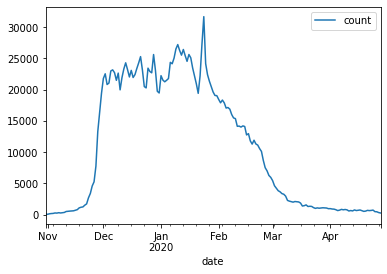

In [7]:
# 1.2.2 입국자(로밍등록자) 추세 chart 확인
ar.plot(x='date',y='count')

In [8]:
# 1.3 Roaming Data의 전처리
# 1.3.1 iso 별로 재배열

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
  if date == row[0][0]:
    pass
  else:
    if not r is None:
      rows.append(r)
    r = {}

  r['arrival'] = row[0][0]
  r[row[0][1]] = row[1][0]
  date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso

,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,sk,...,tp,vu,zw,rs,tk,ug,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,total
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91
2019-11-01,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
2019-11-02,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120
2019-11-03,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159
2019-11-04,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-24,0.0,12.0,84,34.0,19.0,157,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,0.0,18,62.0,44.0,6.0,0.0,3.0,3.0,0.0,9.0,12.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,6.0,3.0,0.0,28.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,711
2020-04-25,0.0,9.0,39,15.0,4.0,111,21.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,0.0,6,73.0,27.0,0.0,0.0,3.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463
2020-04-26,0.0,0.0,42,14.0,10.0,98,6.0,0.0,0.0,0.0,3.0,0.0,0.0,12.0,0.0,3,50.0,40.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,27.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,447


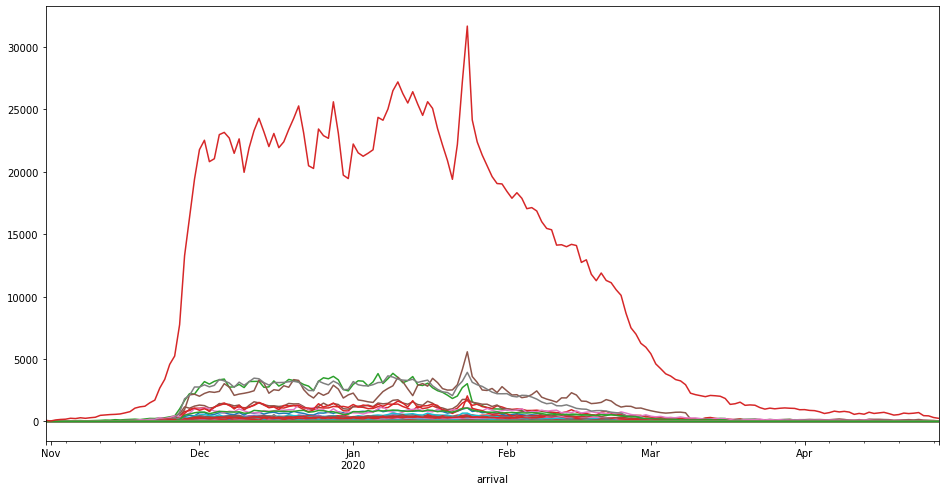

In [9]:
ds_iso.plot(legend=False,figsize=(16,8))

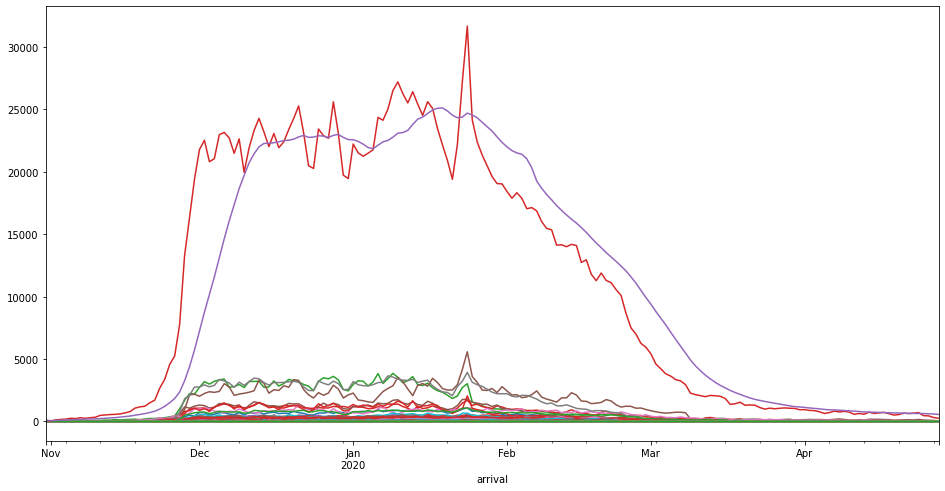

In [10]:
# 1.3.2 2주 (14일) 평균 추세 추가.
raw_ds = ds_iso.copy()
raw_ds['arrival_14ma'] = raw_ds['total'].rolling(window=14, min_periods=0).mean()
raw_ds.plot(legend=False,figsize=(16,8))

In [0]:
# 1.3.3 Trainingset의 구성

# Time-series CNN을 적용하기 위한 전처리
# 1D Convolution을 적용하기 위해..

import numpy as np

# window를 30일로 설정 -> 그냥 잡은 수치
window = 30
#입력 feature 개수.
size = len(raw_ds.columns) - 1 # totoal column 제외
#향후 15일 예측
forecast_days = 15


train_org_y = raw_ds['total'].to_numpy()
data = (raw_ds.drop(columns=['total'])).to_numpy()

train_x = []
train_y = []

for i in range(data.shape[0]-window-forecast_days + 1):
    sub_x = []
    for j in range(window):
        sub_x.append(data[i+j,:])
    train_x.append(sub_x)

    sub_y = []
    for z in range(forecast_days):
        sub_y.append(train_org_y[i + window + z])
    train_y.append(sub_y)

#train_x ,train_y의 준비
train_x = np.asarray(train_x)
train_x = train_x.reshape(-1,window,size)
train_y = np.asarray(train_y)

test_x = data[data.shape[0]-window:data.shape[0],:]

In [12]:
#train_x ,train_y의 내용 확인.
train_x.shape, train_y.shape, test_x.shape

((137, 30, 174), (137, 15), (30, 174))

In [13]:
# 1.4 CNN model 구성 


# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,4, input_shape=(window, size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 4,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(32))
model.add(Dense(forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           89216     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 64)            32832     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 32)            

In [14]:
# 1.5 model training
# 1.5.1 model training
        
#학습 시작...
epochs=50
hist = model.fit(train_x, train_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[==================================================] 50/50 {'loss': 3232434.3959854012, 'mae': 1178.0187, 'r2': 0.966167}


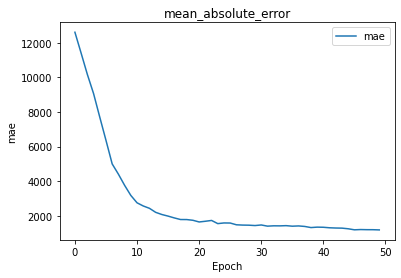

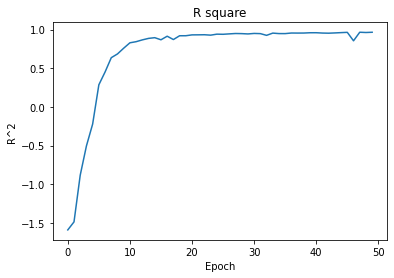

In [15]:
# 1.5.2 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist) 

In [16]:
# 1.5.3 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_x)
predit_y,predit_y.shape

(array([[12396.96   , 13004.575  , 16458.549  , ..., 16955.305  ,
         17649.547  , 17981.139  ],
        [15555.922  , 16502.512  , 20407.223  , ..., 21118.443  ,
         21892.137  , 22116.96   ],
        [18118.475  , 19347.17   , 23051.96   , ..., 24045.54   ,
         24636.56   , 24547.701  ],
        ...,
        [  654.09   ,   638.72217,   651.2328 , ...,   455.61703,
           419.48944,   367.0193 ],
        [  622.618  ,   606.59   ,   625.5759 , ...,   427.14368,
           405.69135,   361.4742 ],
        [  594.9751 ,   583.6532 ,   594.7307 , ...,   404.22836,
           388.7365 ,   345.43118]], dtype=float32), (137, 15))

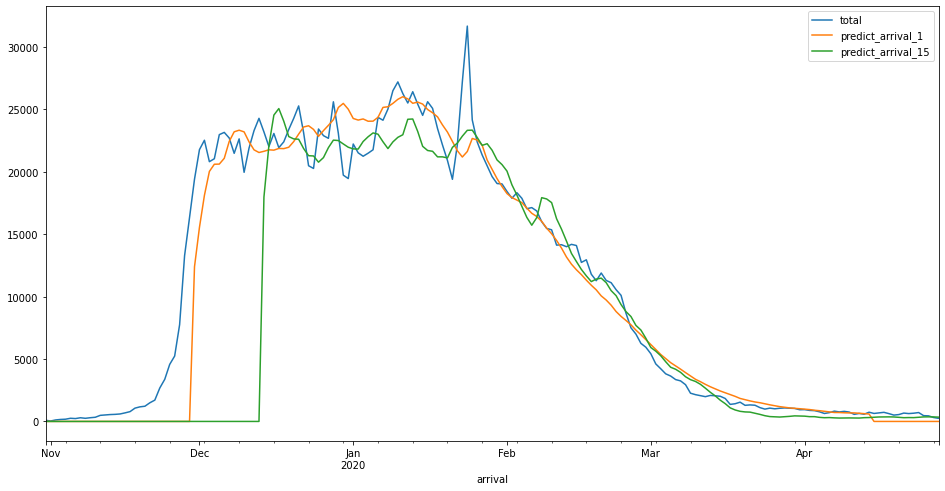

In [17]:
# 1.5.4 과거 Data에서 실등록자 count와 예측 count의 비교 

compare_backdata(predit_y)

In [18]:
# 1.6  향후 15일 예측
# 1.6.1 testset (마지막 30일)의 inference

# trainset의 마지막 날에서 15일까지의 예측
# 마지막 30일치 정보를 input으로...

test_x = test_x.reshape(-1,window,size)
predit_y = model.predict(test_x)
predit_y, predit_y.shape

(array([[373.3042 , 400.79547, 358.13943, 374.66666, 335.39148, 346.58276,
         306.1168 , 341.25995, 298.28625, 273.86646, 264.24652, 251.10118,
         280.54636, 258.18948, 238.17186]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,373.304199,1555
1,2020-04-30,400.795471,1669
2,2020-05-01,358.139435,1492
3,2020-05-02,374.666656,1561
4,2020-05-03,335.391479,1397
5,2020-05-04,346.582764,1444
6,2020-05-05,306.116791,1275
7,2020-05-06,341.259949,1421
8,2020-05-07,298.286255,1242
9,2020-05-08,273.866455,1141


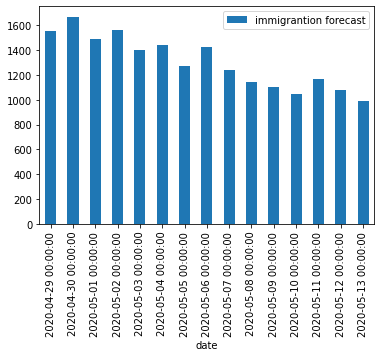

In [19]:
# 1.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [0]:
# 	2.1 News Data의 load

# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns =pd.concat([ns1, ns2], ignore_index=True, sort=False)

In [21]:
ns

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
103822,XWFB2020040900020,"Ching Ming remembrance, home country forever! ...",http://wsjkw.sh.gov.cn/xwfb/20200404/2f54e0e14...,2020-04-09 16:05:21.0,2020-04-04 00:00:00,Shanghai Municioal Health Commission,COVID-19,Viral
103823,ZWYW2020041000002,Guangdong Provincial Health Commission notifie...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-10 18:00:45.0,2020-04-10 00:00:00,Health Commission of Guangdong Province,Dengue fever,Viral
103824,ZWYW2020041500002,Guangdong Provincial Health Commission announc...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:04.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral
103825,ZWYW2020041500003,Guangdong Provincial Health Commission release...,http://wsjkw.gd.gov.cn/zwyw_yqxx/content/post_...,2020-04-15 23:01:13.0,2020-04-15 00:00:00,Health Commission of Guangdong Province,Influenza,Viral


In [22]:
# 	2.2 News Data에 대한 EDA
# 		2.2.1 게시일을 기준으로 News buzz의 합산

cov_news = ns.loc[ns['감염병명'] == 'COVID-19']
cov_news['게시일자'] =  cov_news['게시일자'].str[:10]
cov_buz = pd.DataFrame(cov_news.groupby('게시일자')['감염병명'].count())
cov_buz = cov_buz.loc[cov_buz.index >= '2019-10-31']
cov_buz['date'] = pd.to_datetime(cov_buz.index, format='%Y-%m-%d')
cov_buz = cov_buz.rename(columns={"감염병명":"buz_count"})
cov_buz

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,buz_count,date
게시일자,,
2019-12-01,1,2019-12-01
2019-12-14,2,2019-12-14
2019-12-30,3,2019-12-30
2019-12-31,5,2019-12-31
2020-01-02,1,2020-01-02
...,...,...
2020-04-26,1176,2020-04-26
2020-04-27,1353,2020-04-27
2020-04-28,999,2020-04-28


In [23]:
# 		2.2.2 하루 최대 buzz count 추출

max_buz_per_day = cov_buz['buz_count'].max()
max_buz_per_day

1948

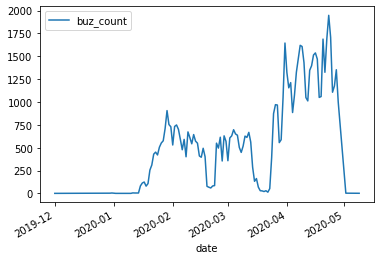

In [24]:
# 		2.2.3 News buzz 추세 Chart

cov_buz.plot(x='date',y='buz_count')

In [25]:
# 	2.3 News Data의 전처리
#		2.3.1 News Data의 doc2vec 처리

!pip install nltk
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
#			2.3.1.1 document의 tokenize & tagging
# 실 Contents는 사용하지 않고 title만 doc2vec 처리...
tagged_data = []
for row in cov_news.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    tagged_data.append(TaggedDocument(words=word_tokenize(title.lower()), tags=[file_name]))
    
len(tagged_data)

73752

In [27]:
#			2.3.1.2 doc2vec model training
# 시간 무지 걸림... 돌리고 커피 한잔 마시기.

vec_size = 20 # 나중에 증가 시킨다.contents를 사용하는 경우, 500~1000정도 ?? 하지만 학습시간은 무지 걸릴거임.
max_epochs = 10 # 이건 나중에 100 정도로 수정...
alpha = 0.025

d2v_model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
d2v_model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    d2v_model.train(tagged_data,
                total_examples=d2v_model.corpus_count,
                epochs=d2v_model.epochs )
    # decrease the learning rate
    d2v_model.alpha -= 0.0002
    # fix the learning rate, no decay
    d2v_model.min_alpha = d2v_model.alpha

d2v_model.save("d2v.model")

print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model Saved


In [28]:
# doc2vec 모델 학습 결과 확인..
from gensim.models.doc2vec import Doc2Vec

d2v_model= Doc2Vec.load("d2v.model")

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(d2v_model.docvecs['AFRO2020013100001'])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[-0.9328556  -1.9461441  -0.60382825  0.94111603  0.7435569   0.4914266
  0.19319862 -0.00688455  0.7392452  -0.355833    0.03090304 -0.8724831
 -0.25773376  0.49164957  0.15354888 -0.49969274 -0.01135013  0.25583228
  0.73791575  0.0608254 ]


In [29]:
#		2.3.4 원시(origin) Trainset의 구성

# doc2vec을 feature로 하는 원시 학습셋을 구성한다.
# 이때, 입국일자을 기준으로 Set을 만드는데...
# 입국일에 news가 없을 때도 있어서, 일관성 있는 양질의 학습셋이 되기는 어려울 듯...
# 준대로 해야지 어쩔 수 없음.
max_buz_per_day = 300 # 하루에 최대 300개의 뉴스를 본다. 나중에 실재 최대치까지 증가..
cov_news['게시일자'] = pd.to_datetime(cov_news['게시일자'], format='%Y-%m-%d')
news_metric = []
from datetime import datetime, timedelta
import numpy as np
# 날짜별 (1948,40) 구성
for row in ar.iterrows():
    date = row[1][1]#datetime(2019,12,31)
    selected_ns = cov_news.loc[cov_news['게시일자'] >= date].loc[cov_news['게시일자'] < (date + timedelta(days=1))]
    #print(date,selected_ns.shape)
    if selected_ns.shape[0] == 0:
        # news가 없는 경우..
        news_metric.append(np.zeros((max_buz_per_day,vec_size)))
    else:
        docv = []
        for nrow in selected_ns.iterrows():
            #print('tag name:',nrow[1][0])
            if len(docv) < max_buz_per_day:
                docv.append(d2v_model.docvecs[nrow[1][0]])
        if len(docv) < max_buz_per_day:
            for i in range(max_buz_per_day-selected_ns.shape[0]):
                docv.append(np.zeros(vec_size))
        news_metric.append(docv)
        
train_temp_x = np.asarray(news_metric)
train_temp_x.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(181, 300, 20)

In [30]:
# 학습셋의 내용 확인...
train_temp_x[162]

array([[ 1.31700861,  0.33760259, -0.75264817, ..., -0.52896881,
        -0.20648064, -0.53536081],
       [-0.53936219, -0.27974078, -0.27252004, ..., -0.28807992,
         0.11395253, -0.07138976],
       [-0.54719007, -0.24901709, -0.65491539, ..., -0.33054256,
         0.76872689, -0.44054466],
       ...,
       [-0.3454687 , -0.50159377,  0.30451417, ..., -0.72671789,
         0.18453066, -0.28220513],
       [-1.71089625,  0.59346753, -1.74194086, ..., -0.68142873,
        -0.01627739,  0.71703488],
       [-1.55215609, -0.5864408 , -0.48111323, ..., -0.79333168,
         0.47006461,  0.20895371]])

In [31]:
# 학습셋의 label... 원시 train_temp_y의 구성
train_temp_y = np.asanyarray(ar['count'])
train_temp_y.shape

(181,)

In [32]:
#	2.4 doc2vec에 의한 Regression Test (Not forecast)
#		2.4.1 doc2vec의 Timeseries model 구성

# 일단, news regression의 설명력을 확인하기 위해...원시 학습을 test 한다.
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Conv1D(128,2, input_shape=(max_buz_per_day,vec_size),padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 2,padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 300, 128)          5248      
_________________________________________________________________
activation_5 (Activation)    (None, 300, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 150, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 150, 64)           16448     
_________________________________________________________________
activation_6 (Activation)    (None, 150, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 75, 32)           

In [37]:
#		2.4.2 원시(origin) Trainset으로 model training

epochs=100
hist = model.fit(train_temp_x, train_temp_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[====================================================================================================] 100/100 {'loss': 44551264.110497236, 'mae': 4512.009, 'r2': 0.53707963}


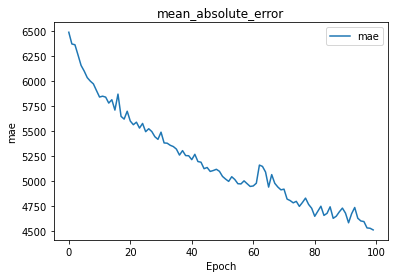

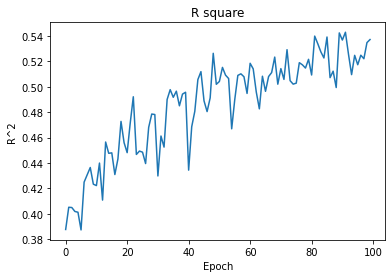

In [38]:
#		2.4.3 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [0]:
#		2.4.4 trainset에 의한 과거 data의 예측 입국자 count 
predit_y = model.predict(train_temp_x)
predit = predit_y.reshape(predit_y.shape[0])

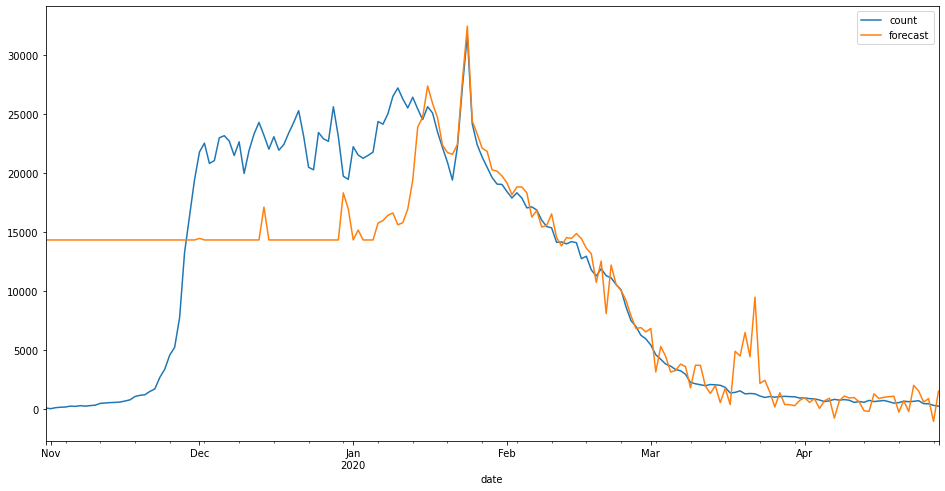

In [40]:
#		2.4.5 실등록자 count와 news기반 예측 count의 비교 chart
predit_result = ar.copy()
predit_result['forecast'] = predit
predit_result.plot(x='date',y=['count','forecast'],figsize=(16,8))

In [0]:
#	2.5 doc2vec에 의한 Forecast regression
#		2.5.1 doc2vec의 Window 적용 Timeseries Trainset의 구성

# 2D Convolution을 적용하여 마치 Image를 convolution 하듯이 학습할 것임
# window의 depth를 image의 channel 처럼 사용
# tensorflow는 image의 chennel을 channel_last로 사용, 
# 이것을 맞추기 위해 moveaxis 를 적용할 것임
# 여기 돌다가 colab 다운 잘됨... 다운 되면 처음부터 다시!

from numpy import moveaxis
# window를 30일로 설정 -> 그냥 잡은 수치
news_window = 30
#향후 15일 예측
news_forecast_days = 15

# 원시 trainset의 사용...
train_news_org_y = train_temp_y
data = train_temp_x

train_news_x = []
train_news_y = []

for i in range(data.shape[0]-news_window-news_forecast_days + 1):
    sub_x = []
    for j in range(news_window):
        sub_x.append(data[i+j,:,:])
    # change channels first to channels last format
    sub_x = np.asarray(sub_x)
    sub_x = moveaxis(sub_x, 0, 2)        
    train_news_x.append(sub_x)

    sub_y = []
    for z in range(news_forecast_days):
        sub_y.append(train_news_org_y[i + news_window + z])
    train_news_y.append(sub_y)

#train_news_x ,train_news_y 준비
train_news_x = np.asarray(train_news_x)
#train_news_x = train_news_x.reshape(-1,news_window,max_buz_per_day,vec_size)
train_news_y = np.asarray(train_news_y)

test_news_x = np.asarray(data[data.shape[0]-news_window:data.shape[0],:,:])
test_news_x = moveaxis(test_news_x, 0, 2) 

In [42]:
#train_news_x ,train_news_y (사실이거는 그냥 train_y와 동일...)의 내용 확인.
train_news_x.shape,  train_news_y.shape, test_news_x.shape

((137, 300, 20, 30), (137, 15), (300, 20, 30))

In [43]:
#		2.5.2 doc2vec Window 의 Timeseries model 구성

# 이게 최적의 layer 구성인지는 모름... 일반적/직관적으로 layer 설정 
# 정성적 비정형 데이터로 정량적 수치 데이터를 추정 하기 때문에... overfit 가능성이 큼
import keras
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

#keras.backend.set_image_data_format('channels_last')

model = Sequential()
model.add(Conv2D(64,(3,3), input_shape=(max_buz_per_day,vec_size,news_window)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(32,activation="relu"))
model.add(Dense(news_forecast_days))
model.add(Activation('linear'))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 18, 64)       17344     
_________________________________________________________________
activation_9 (Activation)    (None, 298, 18, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 6, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 4, 32)         18464     
_________________________________________________________________
activation_10 (Activation)   (None, 97, 4, 32)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 1, 32)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)             

In [44]:
#		2.5.3 doc2vec의 Window 적용 Timeseries Trainset으로 model training

epochs=50
hist = model.fit(train_news_x, train_news_y, epochs=epochs,verbose=0, callbacks=[VerboseCallback(epochs)])

learning:[==================================================] 50/50 {'loss': 3401329.8394160583, 'mae': 1275.4739, 'r2': 0.96436787}


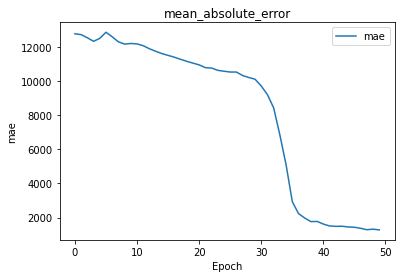

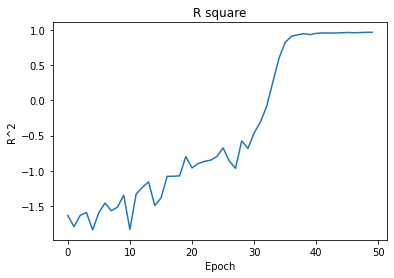

In [45]:
#		2.5.4 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [46]:
#		2.5.5 trainset에 의한 과거 data의 예측 입국자 추정 

predit_news_y = model.predict(train_news_x)
predit_news_y,predit_news_y.shape

(array([[2.4004582e+04, 2.4029518e+04, 2.4018803e+04, ..., 2.2287980e+04,
         2.2210912e+04, 2.2109914e+04],
        [2.4004582e+04, 2.4029518e+04, 2.4018803e+04, ..., 2.2287980e+04,
         2.2210912e+04, 2.2109914e+04],
        [2.4029027e+04, 2.4054000e+04, 2.4043148e+04, ..., 2.2310592e+04,
         2.2233850e+04, 2.2132752e+04],
        ...,
        [6.4262549e+02, 5.2614478e+02, 1.3754506e+02, ..., 1.0301751e+01,
         7.9308998e+01, 6.6816406e+02],
        [6.5917047e+02, 5.3926172e+02, 1.3910927e+02, ..., 8.7896509e+00,
         8.0173294e+01, 6.8648627e+02],
        [6.6727203e+02, 5.4577209e+02, 1.4149280e+02, ..., 8.8458567e+00,
         8.1031105e+01, 6.9507385e+02]], dtype=float32), (137, 15))

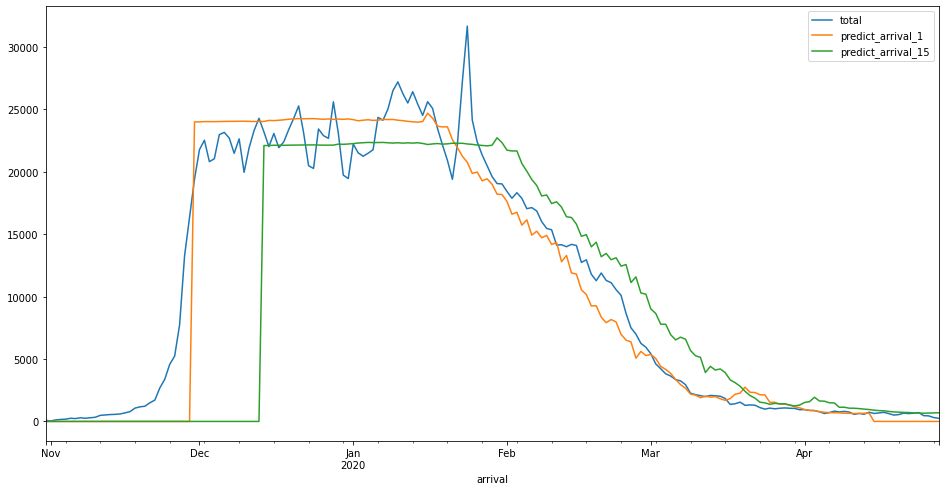

In [47]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
compare_backdata(predit_news_y)

In [48]:
# 	2.6  향후 15일 예측
# 		2.6.1 testset (마지막 30일)의 inference

test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)
predit_y = model.predict(test_news_x)
predit_y,predit_y.shape

(array([[816.73395  , 673.50494  , 196.02196  , 953.5034   , 804.5685   ,
         643.2975   , 687.53595  , 835.977    ,  99.598495 , 536.28705  ,
         245.14426  ,   7.1499434,  27.021862 , 111.93436  , 840.05286  ]],
       dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,816.733948,3403
1,2020-04-30,673.504944,2806
2,2020-05-01,196.021957,816
3,2020-05-02,953.503418,3972
4,2020-05-03,804.568481,3352
5,2020-05-04,643.297485,2680
6,2020-05-05,687.535950,2864
7,2020-05-06,835.976990,3483
8,2020-05-07,99.598495,414
9,2020-05-08,536.287048,2234


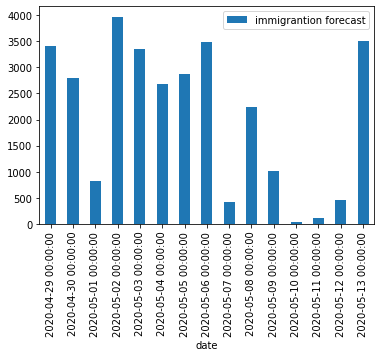

In [49]:
# 		2.6.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [0]:
# 이제 긴 학습을 해야 해서..
# 돌다가 죽을 것을 대비해서 입출력 dataset을 일단 저장 한다.

from numpy import save
# define data
data = np.asarray([train_x,train_y,test_x,train_news_x,train_news_y,test_news_x])
# save to npy file
save('dataset.npy', data)

In [52]:
if True==0:
    # load numpy array from npy file
    from numpy import load
    # load dict of arrays
    [train_x,train_y,test_x,train_news_x,train_news_y,test_news_x] = load('dataset.npy', allow_pickle=True)

train_x.shape

(137, 30, 174)

In [53]:
#	3.2 Numeric timeseries and unstructured timeseries combined model 구성
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate


# define two sets of inputs
input_roaming = Input(shape=(window, size))
input_news = Input(shape=(max_buz_per_day,vec_size,news_window))

# 로밍등록자에 대한 1D Convilution layer 구성
x = Conv1D(128,4, activation="relu",padding="same")(input_roaming)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(32,4, activation="relu",padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Model(inputs=input_roaming, outputs=x)


# news에 대한 2D Convolution layer 구성
y = Conv2D(64,(3,3), activation="relu")(input_news)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Conv2D(32,(2,2), activation="relu")(y)
y = MaxPooling2D(pool_size=(3,3))(y)
y = Flatten()(y)
y = Dense(1024,activation="relu")(y)
#y = Dropout(0.5)(y)
y = Dense(32,activation="relu")(y)
y = Model(inputs=input_news, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(forecast_days, activation="linear")(combined)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])

print(model.summary())

model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

print("save to combined_model.json")

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 174)      0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 30, 128)      89216       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 300, 20, 30)  0                                            
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 15, 128)      0           conv1d_7[0][0]                   
____________________________________________________________________________________________

In [54]:
#	3.3 Numeric timeseries and unstructured timeseries data train

def train_combined_model(trial,epochs=30,verbose=0):
    from keras.models import model_from_json
    json_file = open("combined_model.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
    #print(model.summary())
    print(str(trial),"th Trial")
    if verbose == 0:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=0,callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit([train_x,train_news_x], train_y, epochs=epochs,verbose=1)
    return model,hist

model,hist = train_combined_model(1,epochs=100)

1 th Trial
learning:[====================================================================================================] 100/100 {'loss': 1651097.6268248176, 'mae': 730.51105, 'r2': 0.9826838}


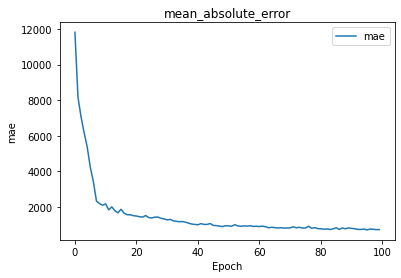

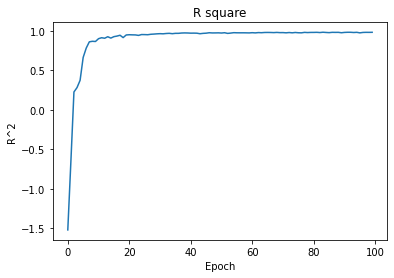

In [55]:
#		3.3.1 학습에 대한 mean_absolute_error 확인.

plot_mae(hist)
plot_r2(hist)

In [56]:
#		3.3.2 trainset에 의한 과거 data의 예측 입국자 count 

predit_y = model.predict([train_x,train_news_x])
predit_y,predit_y.shape

(array([[20731.691  , 20569.012  , 21110.316  , ..., 21938.303  ,
         22054.773  , 21867.887  ],
        [22332.2    , 22225.238  , 22330.426  , ..., 23855.65   ,
         23871.852  , 23375.246  ],
        [22206.92   , 22181.934  , 21811.95   , ..., 23943.98   ,
         23888.691  , 23033.887  ],
        ...,
        [  860.57837,   782.4566 ,   832.1178 , ...,   531.0193 ,
           382.72318,   374.1359 ],
        [  854.29626,   787.5015 ,   843.5767 , ...,   531.944  ,
           375.76553,   367.70197],
        [  861.5887 ,   775.77075,   827.9867 , ...,   488.97827,
           328.26508,   333.1996 ]], dtype=float32), (137, 15))

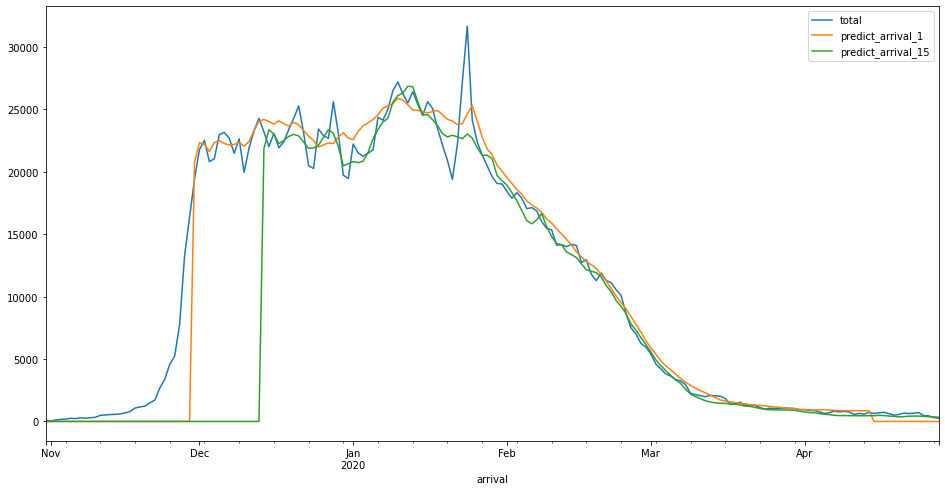

In [57]:
# window와 forecast_days에 의해 실제 날자와 차이나는 부분의 보정 처리...
compare_backdata(predit_y)

In [58]:
# 	3.4  향후 15일 예측
# 		3.4.1 testset (마지막 30일)의 inference

predit_y = model.predict([test_x,test_news_x])
predit_y,predit_y.shape

(array([[1145.2372 , 1132.7253 , 1064.5889 , 1038.7301 ,  785.3739 ,
          723.2311 ,  465.48776,  311.0519 ,  118.40648,   97.08647,
          138.50162,  -72.60418,  -77.20643, -204.49837, -192.61597]],
       dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,1145.237183,4771
1,2020-04-30,1132.725342,4719
2,2020-05-01,1064.588867,4435
3,2020-05-02,1038.730103,4328
4,2020-05-03,785.373901,3272
5,2020-05-04,723.231079,3013
6,2020-05-05,465.487762,1939
7,2020-05-06,311.051910,1296
8,2020-05-07,118.406479,493
9,2020-05-08,97.086472,404


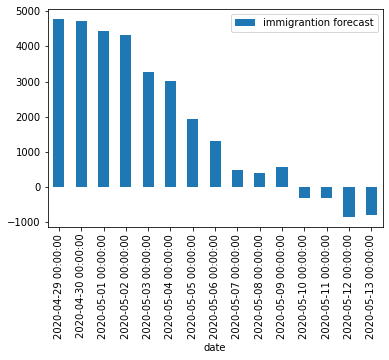

In [59]:
# 		3.4.2 로밍등록자 예측 Count에서 실입국자 보정 처리 및 결과 표출

display_result(predit_y)

In [0]:
#	3.5 ensemble에 의한 일관된 결과 예측
#		3.5.1 ensemble model 생성

# 일관된 예측 결과를 만들기 위해, 동일 모델 10개의 앙상블 처리
# 시간 무지 오래 걸림 식사하고 오세요~
# 밥먹고 왔는데 중간에 실패 (Resource exhaustion) 되어 있을 수 있음...
# 너무 오래 걸리면, epoch=200 을 조정 한다.
import dill

ensemble = []
for i in range(10):
  model,hist = train_combined_model(i+1,epochs=100,verbose=0)
  ensemble.append(model)
    
print("Wait! saving model...")    
file = open("ensemble.mdl", 'wb')
dill.dump(ensemble, file)
file.close()
        
print("Complete!!")


1 th Trial
learning:[============================........................................................................] 28/100 {'loss': 4072750.4562043794, 'mae': 1397.4626, 'r2': 0.95563745}

In [0]:
if True == 0:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()

# 		ensemble_predict method define~
def ensemble_predict(input_roam,input_news):

    ensemble_predit_y =  np.asarray([m.predict([input_roam,input_news]) for m in ensemble])
    predit_y = np.mean(ensemble_predit_y,axis=0)
    return predit_y  

In [74]:
# trainset에 의한 과거 data의 예측 입국자 count 

predit_y = ensemble_predict(train_x,train_news_x)
predit_y,predit_y.shape

(array([[19436.941  , 20120.027  , 20160.6    , ..., 22047.615  ,
         21944.807  , 21558.127  ],
        [21292.52   , 21902.457  , 21999.463  , ..., 23627.744  ,
         23414.438  , 23139.969  ],
        [21874.758  , 22285.832  , 22471.02   , ..., 23766.705  ,
         23460.984  , 23377.754  ],
        ...,
        [  731.47217,   647.6702 ,   631.29974, ...,   647.9755 ,
           604.0218 ,   607.10583],
        [  746.3429 ,   655.262  ,   625.56934, ...,   597.10657,
           560.3676 ,   563.7782 ],
        [  758.8121 ,   667.3833 ,   638.167  , ...,   585.9556 ,
           553.01764,   551.01556]], dtype=float32), (137, 15))

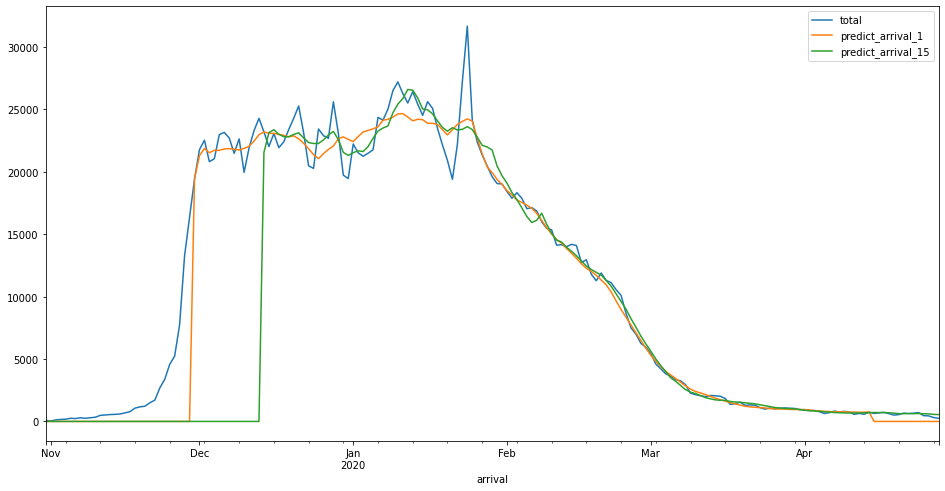

In [75]:
compare_backdata(predit_y)

In [76]:
# 
test_x = test_x.reshape(-1,window,size)
test_news_x = test_news_x.reshape(-1,max_buz_per_day,vec_size,news_window)

predit_y = ensemble_predict(test_x,test_news_x)
predit_y, predit_y.shape

(array([[677.6266 , 600.40607, 570.86523, 538.8275 , 507.98846, 471.50992,
         442.7561 , 409.05148, 458.8182 , 536.2654 , 591.60754, 614.3804 ,
         577.6412 , 488.9192 , 522.52386]], dtype=float32), (1, 15))

,date,roaming register forecate,immigrantion forecast
0,2020-04-29,677.626587,2823
1,2020-04-30,600.406067,2501
2,2020-05-01,570.865234,2378
3,2020-05-02,538.827515,2245
4,2020-05-03,507.988464,2116
5,2020-05-04,471.509918,1964
6,2020-05-05,442.756104,1844
7,2020-05-06,409.051483,1704
8,2020-05-07,458.818207,1911
9,2020-05-08,536.265381,2234


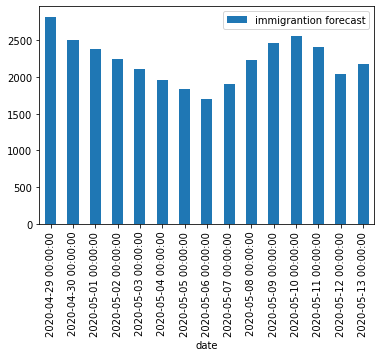

In [77]:
#		3.5.2 최종 결과
display_result(predit_y)